In [1]:
# Para visuzalización en notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
#import seaborn as sns
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
from IPython.display import Audio, Markdown, Image

def dmd(x):
    display(Markdown(x))

# Números y Datos
import numpy as np
import pandas as pd
import random

# Clustering (scipy)
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster

# Clustering (sklearn)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors

# Preparación de un dataset de prueba

In [2]:
a=np.concatenate((np.tile(2,40),np.tile(6,40),np.tile(12,40),np.tile(19,40),np.tile(26,40)))
b=np.concatenate((np.tile(3,40),np.tile(6,40),np.tile(14,120)))
c=np.concatenate((np.tile(12,80),np.tile(18,40),np.tile(2,40),np.tile(30,40)))
clase=np.concatenate((np.tile('a',40),np.tile('b',40),np.tile('c',40),np.tile('d',40),np.tile('e',40)))

In [3]:
# Sin ruido
df0 = pd.DataFrame({'A': a, 'B': b, 'C': c, 'clase': clase})
df0

,A,B,C,clase
0,2,3,12,a
1,2,3,12,a
2,2,3,12,a
3,2,3,12,a
4,2,3,12,a
5,2,3,12,a
6,2,3,12,a
7,2,3,12,a
8,2,3,12,a
9,2,3,12,a


In [4]:
# Sin ruido
df0 = pd.DataFrame({'A': a, 'B': b, 'C': c, 'clase': clase})

# Con poco ruido
atmp = a + np.random.normal(0, 1.0, 200)
btmp = b + np.random.normal(0, 1.0, 200)
ctmp = c + np.random.normal(0, 1.0, 200)
df1 = pd.DataFrame({'A': atmp, 'B': btmp, 'C': ctmp, 'clase': clase})

# Con más ruido
atmp = a + np.random.normal(0, 5.0, 200)
btmp = b + np.random.normal(0, 5.0, 200)
ctmp = c + np.random.normal(0, 5.0, 200)
df2 = pd.DataFrame({'A': atmp, 'B': btmp, 'C': ctmp, 'clase': clase})

In [5]:
# Aleatorizo el orden de los registros para que sea más real
df0 = df0.sample(frac=1).reset_index(drop=True)
df1 = df1.sample(frac=1).reset_index(drop=True)
df2 = df2.sample(frac=1).reset_index(drop=True)

/home/juank/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


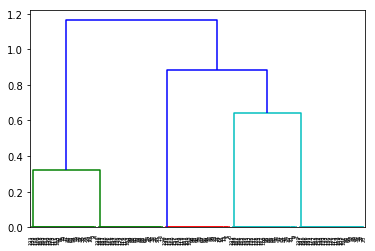

In [6]:
df=df0.drop(['clase'], axis=1)
df=scaler.fit_transform(df)
z = linkage(df, method='average', metric='euclidean')
plt.figure()
dn = dendrogram(z)

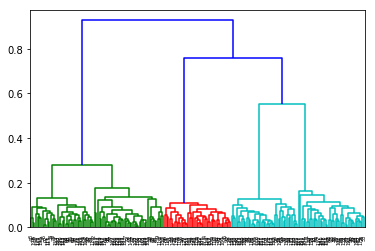

In [7]:
df=df1.drop(['clase'], axis=1)
df=scaler.fit_transform(df)
z = linkage(df, method='average', metric='euclidean')
plt.figure()
dn = dendrogram(z)

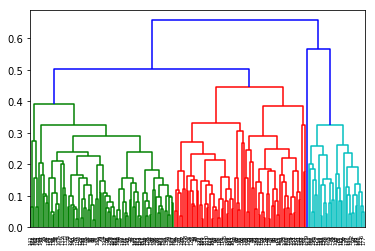

In [8]:
df=df2.drop(['clase'], axis=1)
df=scaler.fit_transform(df)
z = linkage(df, method='average', metric='euclidean')
plt.figure()
dn = dendrogram(z)

# Tendencia al clustering (Hopkins)
El método de Hopkins consiste en generar p puntos distribuidos al azar en el espacio muestral, y además extraer p puntos reales del dataset. Luego se calculan las distancias a los vecinos más próximos dentro del subconjunto de datos generados al azar (u) y dentro del subconjunto de datos extraídos del dataset (w), con estos se calcula el coeficiente de Hopkins (H) como sum_i(w_i)/(sum_i(u_i)+sum_i(w_i)). Si los nuevos puntos están igual de alejados que los tomados al azar, entonces sum(u) ~ sum(w) y H ~ 0.5. En cambio, si sum(u) >> sum(w), es decir que en promedio están menos agrupados los que se encuentran al azar, entonces H << 0.5.

In [9]:
n = df.shape[0] # filas
d = df.shape[1] # columnas
m = 20 # cantidad de puntos al azar

nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute').fit(df) # buscador de vecinos

rand_ind = random.sample(range(0, n, 1), m) # indices al azar

ui = []
wi = []
for j in range(0, m):
    u_dist, _ = nbrs.kneighbors(np.random.normal(size=(1, d)).reshape(1, -1), 2, return_distance=True) # distancia a los nuevos puntos
    ui.append(u_dist[0][1])
    w_dist, _ = nbrs.kneighbors(df[rand_ind[j]].reshape(1, -1), 2, return_distance=True) # distancia a los puntos al azar
    wi.append(w_dist[0][1])

H = sum(wi) / (sum(ui) + sum(wi))
H

0.05039199545568989

In [10]:
df.shape

(200, 3)

In [11]:
def Hopkins(df,*args):
    n = df.shape[0] # filas
    d = df.shape[1] # columnas
    if not args:
        print("Numero de puntos al azar por defecto")
        m = int(0.1 * n) # cantidad de puntos al azar (default)
    else:
        m = args[0] # cantidad de puntos al azar

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute').fit(df) # buscador de vecinos

    rand_ind = random.sample(range(0, n, 1), m) # indices al azar

    ui = []
    wi = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(np.random.normal(size=(1, d)).reshape(1, -1), 2, return_distance=True) # distancia a los nuevos puntos
        ui.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(df[rand_ind[j]].reshape(1, -1), 2, return_distance=True) # distancia a los puntos al azar
        wi.append(w_dist[0][1])

    H = sum(wi) / (sum(ui) + sum(wi))
    return H

In [12]:
df=df0.drop(['clase'], axis=1)
df=scaler.fit_transform(df)
Hopkins(df)

Numero de puntos al azar por defecto


/home/juank/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


0.0

In [13]:
df=df1.drop(['clase'], axis=1)
df=scaler.fit_transform(df)
Hopkins(df)

Numero de puntos al azar por defecto


0.02070042855598902

In [14]:
df=df2.drop(['clase'], axis=1)
df=scaler.fit_transform(df)
Hopkins(df,20)

0.05170509926709944

# Validación externa (en k-medias)
Ahora vamos a usar la variable 'clase'

In [15]:
df=df0.drop(['clase'], axis=1)
kmeans0 = KMeans(n_clusters=5, random_state=0).fit(df)
kmeans0.labels_

array([2, 2, 1, 4, 1, 0, 0, 0, 1, 2, 1, 2, 4, 0, 1, 0, 0, 4, 2, 0, 4, 0,
       0, 0, 1, 0, 4, 3, 3, 1, 2, 3, 1, 4, 2, 3, 3, 4, 1, 1, 4, 1, 4, 3,
       0, 3, 2, 0, 0, 0, 2, 2, 3, 1, 4, 1, 2, 3, 1, 1, 0, 4, 4, 1, 3, 4,
       1, 0, 4, 0, 1, 1, 2, 0, 1, 1, 4, 2, 1, 4, 4, 2, 3, 2, 2, 4, 2, 2,
       4, 4, 0, 3, 0, 0, 4, 2, 0, 1, 0, 2, 0, 3, 3, 4, 0, 1, 0, 0, 3, 3,
       4, 0, 4, 3, 3, 1, 4, 1, 1, 0, 2, 2, 4, 3, 2, 2, 3, 3, 2, 0, 3, 2,
       2, 0, 4, 2, 4, 3, 3, 3, 4, 0, 2, 2, 3, 2, 1, 4, 3, 1, 1, 2, 3, 1,
       2, 2, 2, 0, 3, 1, 0, 2, 2, 1, 4, 3, 4, 3, 1, 1, 1, 4, 0, 0, 3, 0,
       4, 3, 1, 1, 4, 3, 4, 4, 4, 3, 3, 1, 2, 4, 3, 3, 0, 1, 2, 2, 0, 3,
       4, 3], dtype=int32)

In [16]:
tmp = pd.DataFrame({'Labels': df0.clase, 'Clusters': kmeans0.labels_})# Crear un DataFrame con Labels y Clusters como columnas
ct0 = pd.crosstab(tmp['Labels'], tmp['Clusters']) # Crear una matriz de confusion: ct
ct0

Clusters,0,1,2,3,4
Labels,,,,,
a,0,40,0,0,0
b,0,0,0,0,40
c,0,0,0,40,0
d,0,0,40,0,0
e,40,0,0,0,0


In [17]:
df=df2.drop(['clase'], axis=1)
kmeans2 = KMeans(n_clusters=5, random_state=0).fit(df)
tmp = pd.DataFrame({'Labels': df2.clase, 'Clusters': kmeans2.labels_})
ct = pd.crosstab(tmp['Labels'], tmp['Clusters'])
ct

Clusters,0,1,2,3,4
Labels,,,,,
a,28,0,0,0,12
b,15,0,0,2,23
c,0,0,0,30,10
d,0,0,37,1,2
e,0,34,0,6,0


In [18]:
df=df1.drop(['clase'], axis=1)
kmeans1 = KMeans(n_clusters=5,init = 'random').fit(df)
tmp = pd.DataFrame({'Labels': df1.clase, 'Clusters': kmeans1.labels_})
ct1 = pd.crosstab(tmp['Labels'], tmp['Clusters'])
ct1

Clusters,0,1,2,3,4
Labels,,,,,
a,0,40,0,0,0
b,40,0,0,0,0
c,0,0,0,40,0
d,0,0,40,0,0
e,0,0,0,0,40


In [19]:
df=df2.drop(['clase'], axis=1)
kmeans2 = KMeans(n_clusters=5,init = 'random').fit(df)
tmp = pd.DataFrame({'Labels': df2.clase, 'Clusters': kmeans2.labels_})
ct2 = pd.crosstab(tmp['Labels'], tmp['Clusters'])
ct2

Clusters,0,1,2,3,4
Labels,,,,,
a,0,28,12,0,0
b,0,15,23,0,2
c,0,0,10,0,30
d,0,0,2,37,1
e,34,0,0,0,6


In [20]:
df=df0.drop(['clase'], axis=1)
kmeans00 = KMeans(n_clusters=3, random_state=0).fit(df)
tmp = pd.DataFrame({'Labels': df0.clase, 'Clusters': kmeans00.labels_})
ct = pd.crosstab(tmp['Labels'], tmp['Clusters'])
ct

Clusters,0,1,2
Labels,,,
a,0,40,0
b,0,40,0
c,0,40,0
d,0,0,40
e,40,0,0


## Criterio de van Dongen

In [21]:
n2=2*(sum(ct[0])+sum(ct[1]))
sumi = sum(ct.apply(np.max,axis=1))
sumj = sum(ct.apply(np.max,axis=0))
maxsumi = np.max(ct.apply(sum,axis=1))
maxsumj = np.max(ct.apply(sum,axis=0))
vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)

In [22]:
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

In [23]:
vanDongen(ct0)

0.0

In [24]:
vanDongen(ct1)

0.0

In [25]:
vanDongen(ct2)

0.30670926517571884

## Efecto uniforme
Es importante hacer este tipo de evaluaciones porque el método de k-medias tiende
a formar grupos de tamaño uniforme, aun cuando las clases sean claramente no
balanceadas. Esto se llama el "efecto uniforme". Una forma rápida de evaluarlo es
calcular el coeficiente de variación (CV = desvío estándar/media) de la distribución
del tamaño de las clases. Por ejemplo, supongamos dos datasets con seis clases. En
el primer dataset el tamaño de cada clase es bastante uniforme y el segundo es
sesgado:

In [26]:
ds1_n_clases = [55,58,51,59,49,50]
ds2_n_clases = [5,17,62,30,128,80]

In [27]:
cv_ds1_n_clases = np.std(ds1_n_clases)/np.mean(ds1_n_clases)
cv_ds2_n_clases = np.std(ds2_n_clases)/np.mean(ds2_n_clases)

In [28]:
print([cv_ds1_n_clases,cv_ds2_n_clases])

[0.07269999944546351, 0.7817702301317111]


En forma empírica se mostró que si las clases presentan un CV mayor que 0.85 es
bastante posible que el método de k-medias introduzca alguna distorsión en el
resultado. Si se están probando variaciones de métodos o parámetros de clustering,
una forma rápida de evaluar el efecto uniforme es calcular diferencias entre el CV de
las clases conocidas y las de las variantes probadas.
El método de k-medias también puede ser sensible a diferencias en densidad de los
grupos y a la presencia de grupos no esféricos.

## Indice Rand


In [29]:
df=df0.drop(['clase'], axis=1)
kmeans0 = KMeans(n_clusters=5, random_state=0).fit(df)
ari0 = adjusted_rand_score(df0.clase, kmeans0.labels_)
ari0

1.0

In [30]:
df=df1.drop(['clase'], axis=1)
kmeans1 = KMeans(n_clusters=5, random_state=0).fit(df)
ari1 = adjusted_rand_score(df1.clase, kmeans1.labels_)
ari1

1.0

In [31]:
df=df2.drop(['clase'], axis=1)
kmeans2 = KMeans(n_clusters=5, random_state=0).fit(df)
ari2 = adjusted_rand_score(df2.clase, kmeans2.labels_)
ari2

0.5557653241828856

# Validación Interna
Se utilización los conceptos de cohesión (cuán cerca están dentro de un cluster) y separación (cuán separados están los clusters)

In [32]:
from sklearn.metrics.pairwise import euclidean_distances

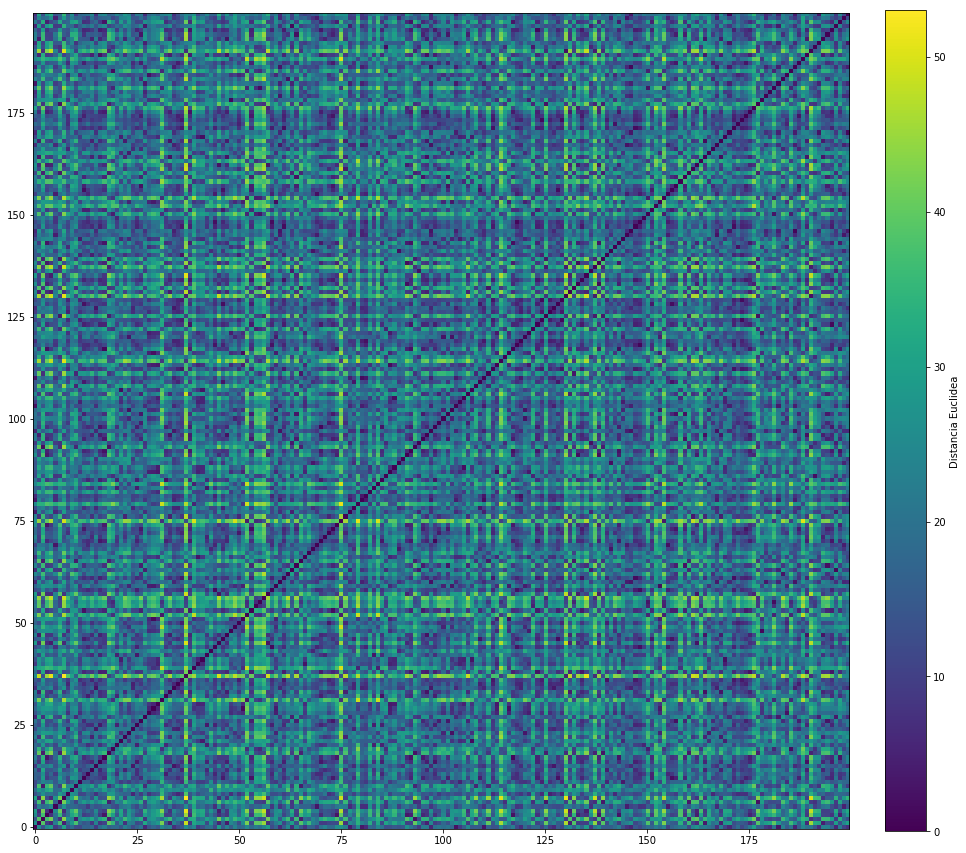

In [33]:
df = df2.drop(['clase'], axis=1)
d  = euclidean_distances(df, df)

plt.figure(figsize=(16,16))
plt.imshow(d,aspect='auto',origin='bottom');
plt.colorbar(label='Distancia Euclidea',fraction=0.046, pad=0.04)
plt.gca().set_aspect('equal')
#plt.xlabel('Tiempo (segundos)');

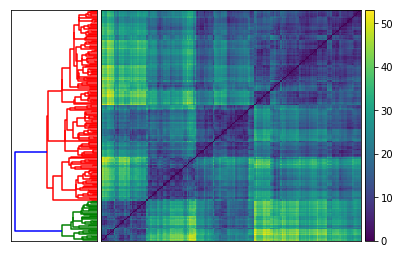

In [34]:
import pylab

# Abrir figura nueva
fig = pylab.figure()

# Calcular dendrograma y graficar.
axdendro = fig.add_axes([0.09,0.1,0.2,0.8])
Y = linkage(d, method='centroid')
Z = dendrogram(Y, orientation='right')
axdendro.set_xticks([])
axdendro.set_yticks([])
axdendro.invert_xaxis()

# Graficar la matriz de distancias.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.8])
index = Z['leaves']
d = d[index,:]
d = d[:,index]
im = axmatrix.matshow(d, aspect='auto', origin='lower')
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Graficar la barra de color
axcolor = fig.add_axes([0.91,0.1,0.02,0.8])
pylab.colorbar(im, cax=axcolor)

In [35]:
df = df2.drop(['clase'], axis=1)
d  = euclidean_distances(df, df)
kmeans2 = KMeans(n_clusters=5, random_state=0).fit(df)

In [36]:
## Silhuette usando sklearn
silhouette_avg = silhouette_score(df, kmeans2.labels_)
silhouette_avg

0.32083204472819227

In [37]:
## Silhuette usando sklearn
sample_silhouette_values = silhouette_samples(df, kmeans2.labels_)
sample_silhouette_values

array([ 0.46665628,  0.38217338,  0.31454933,  0.39099784,  0.32137377,
        0.37219489,  0.4019802 ,  0.33607902,  0.30199264,  0.02974479,
        0.15463795,  0.11318939,  0.27762916,  0.12228919,  0.15477673,
        0.12772351,  0.32710417,  0.25625217,  0.46373465,  0.30479896,
        0.27979091,  0.4165354 ,  0.15580891,  0.49244421,  0.14537182,
        0.23561562,  0.35640754,  0.24964428,  0.34870987,  0.56386334,
        0.56050897,  0.38803336,  0.33070377,  0.21175749,  0.25481494,
        0.33556439,  0.23629434,  0.52154405,  0.19266838,  0.54406205,
        0.32293986,  0.47443935,  0.28712592,  0.12790692,  0.08791473,
        0.43124573,  0.24597969,  0.43245128,  0.28175359,  0.35682718,
        0.27702048,  0.54765858,  0.44133928,  0.23119587,  0.50062142,
        0.51717828,  0.47916934,  0.46015792,  0.10095925,  0.51473167,
        0.51198607,  0.14445089,  0.30835402,  0.18986716,  0.16680967,
        0.37216688,  0.19281109,  0.05997039,  0.07867156,  0.26

In [38]:
# Estimar el coeficiente de Silhouette para cada cluster
cluster_labels = kmeans0.labels_
n_clusters=len(np.unique(cluster_labels))
ith_cluster_silhouette_avg = []
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_avg.append(np.mean(ith_cluster_silhouette_values)) 
ith_cluster_silhouette_avg

[0.29995473863264693,
 0.3244369181266811,
 0.30378602499362606,
 0.3645889092176338,
 0.31139363267037334]

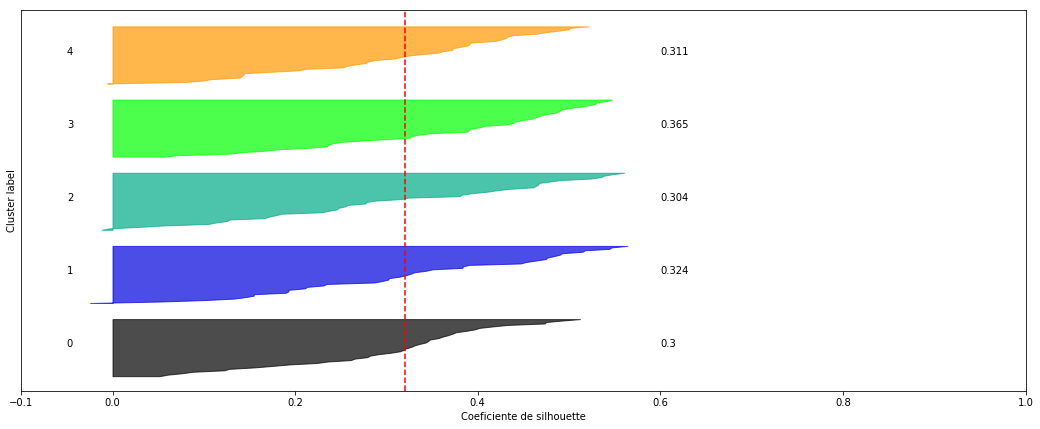

In [45]:
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Marcar los graficos de Silhouette con el numero de cluster
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    # Marcar los graficos de Silhouette con el Silhuette promedio del cluster
    ax1.text(0.6, y_lower + 0.5 * size_cluster_i, str(round(ith_cluster_silhouette_avg[i],3)))

    # Calcular donde comenzar el proximo grafixo
    y_lower = y_upper + 10 # Marco una distancia de 10 entre graficos para que haya un espacio

ax1.set_xlabel("Coeficiente de silhouette")
ax1.set_ylabel("Cluster label")

# La linea vertical es el Silhouette promedio
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

## Validación de CLustering Jerarquico (Coeficiente de correlación cofenético)

In [ ]:
df=df2.drop(['clase'], axis=1)
df=scaler.fit_transform(df)
z = linkage(df, method='average', metric='euclidean')
plt.figure()
dn = dendrogram(
                z,
                show_leaf_counts=False,
                leaf_rotation=90.,
                leaf_font_size=12.,
                show_contracted=True,
)
plt.title('Dendrograma Clustering Jerarquico')
plt.ylabel('distancia')
plt.show()
c, coph_dists = cophenet(z, pdist(df))
c

In [ ]:
# Mostrar solo los p clusters mas altos
dendrogram(
    z,
    truncate_mode='lastp',  
    p=10,
    show_leaf_counts=False,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
)
plt.title('Dendrograma Clustering Jerarquico (truncado)')
plt.ylabel('distancia')
plt.show()

In [ ]:
cluster_labels = fcluster(z, 0.5, criterion='distance')
np.unique(cluster_labels) 
#cluster_labels

In [ ]:
cluster_labels = fcluster(z, 5, criterion='maxclust')
np.unique(cluster_labels)

In [ ]:
ari2 = adjusted_rand_score(df2.clase, cluster_labels)
ari2